In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from torchvision.datasets import MNIST
import torchvision.transforms as tsfm
import torchvision

from torch.utils.data import DataLoader

In [2]:
#transforms = tsfm.Compose([tsfm.RandomAffine(70,(.1,.2),(.8,1)),tsfm.ToTensor()])
transforms = tsfm.Compose([tsfm.ToTensor()])

In [3]:
dataset = MNIST(root=r'C:\Users\lpott\Desktop\Coursera\Projects\Transformer',train=True,transform=transforms,download=True)

In [4]:
batch_size = 64
trainloader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

In [5]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer,self).__init__()
        self.conv1 = nn.Conv2d(6,16,3)
        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128,6) 
        
    def forward(self,x):
        # Batch x 16 x 7 x 7
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = x.view(-1,self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        return self.fc2(x).view(-1,2,3)
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # input Batch x 1 x 28 x 28

        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        self.transformer = Transformer()
        
    def forward(self,x):
        # Max pooling over a (2,2) window
        # return Batch x 6 x 13 x 13
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
                
        # transform section
        theta = self.transformer(x)
        flow_field = F.affine_grid(theta,torch.Size((x.shape[0],6,13,13)))
        x = F.grid_sample(x,flow_field)
        
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def transform(self,x):
        with torch.no_grad():
            x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
            theta = self.transformer(x)
            return theta

In [7]:
device = torch.device('cuda:0')

In [8]:
CNN = Net().to(device)

In [9]:
num_epochs = 20
lr = 0.005
batch_size = 64
print_every = 3

In [10]:
optimizer = optim.Adam(CNN.parameters(),lr=lr)

In [11]:
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(num_epochs):
    LOSS = 0
    for imgs,labels in trainloader:
        output = CNN(imgs.to(device))
        
        loss = criterion(output,labels.to(device))
        
        optimizer.zero_grad()
        
        loss.backward()

        optimizer.step()
    
        LOSS += loss.detach().item()*output.shape[0]
    if (epoch+1)%print_every == 0:   
        print(LOSS/len(dataset))

0.02136371356944243
0.02015869681139787
0.028594475571562847
0.02313761395687858


## Visualize transformer...

In [13]:
pil = tsfm.ToPILImage()

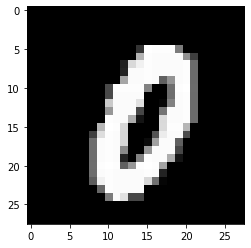

In [42]:
x = transforms(pil(dataset[34][0]))
plt.imshow(x.squeeze().numpy(),cmap='gray')
plt.show()

In [43]:
x = x.unsqueeze(0).to(device)

In [44]:
theta = CNN.transform(x)

In [45]:
flow_field = F.affine_grid(theta,torch.Size((x.shape[0],1,28,28)))
y = F.grid_sample(x,flow_field)

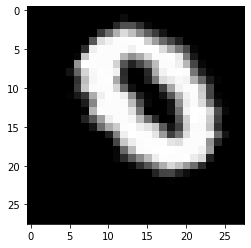

In [46]:
plt.imshow(y.cpu().detach().squeeze().numpy(),cmap='gray')

In [19]:
import torchvision

In [20]:
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        input_tensor = next(iter(trainloader))[0].to(device)
        theta = CNN.transform(input_tensor)
        flow_field = F.affine_grid(theta,torch.Size((theta.shape[0],1,28,28)))
        
        input_tensor = input_tensor.cpu()
        transformed_input_tensor = F.grid_sample(input_tensor,flow_field.cpu())

        in_grid = torchvision.utils.make_grid(input_tensor).permute(1,2,0).numpy()

        out_grid = torchvision.utils.make_grid(transformed_input_tensor).permute(1,2,0).numpy()

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2,figsize=(20,20))
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

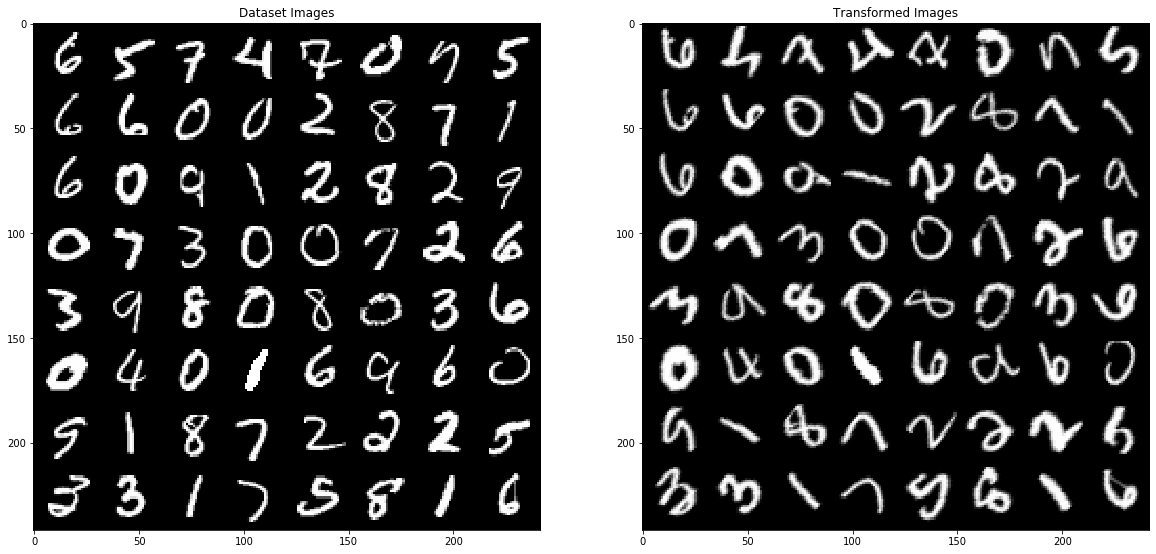

In [21]:
visualize_stn()